In [1]:
import os

os.environ["CHECKPOINTS_PATH"] = "../checkpoints"
os.environ["TRACKING_RESULTS_PATH"] = "data/processed_tracking_results"

import itertools
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from src.api.models.pydantic import SimRoomClassDTO
from src.config import UNKNOWN_CLASS_ID, TOBII_GLASSES_FPS, VIEWED_RADIUS
from ultralytics import YOLO
import subprocess

from experiment.settings import (
    CLASS_ID_TO_NAME,
    FULLY_LABELED_RECORDINGS,
    GAZE_SEGMENTATION_RESULTS_PATH,
    RECORDINGS_PATH,
    RECORDING_FRAMES_PATH,
    OBJECT_DETECTION_MODELS_PATH,
    COMPARISON_SETS_PATH,
    NAME_TO_CLASS_ID,
    OBJECT_DETECTION_PREDICTIONS_PATH,
    FINAL_PREDICTION_VIDEOS_PATH
)
from src.api.db import Session, engine
from src.api.repositories import simrooms_repo
from src.api.services import simrooms_service, gaze_service
import cv2
import numpy as np
import tempfile
from src.utils import extract_frames_to_dir
import albumentations as A
from tqdm import tqdm
import json
from torchvision.ops import box_iou
import torch
import collections
from src.api.utils import image_utils
from experiment import experiment_utils


In [2]:
IMG_CROP_SIZE = 640
IMG_CROP_SIZE_HALF = IMG_CROP_SIZE // 2

models = list(OBJECT_DETECTION_MODELS_PATH.glob("*.pt"))

# Object Detection Inference

## Inference - Create Comparison Sets

In [3]:
def get_frame_to_gaze_segmentation_data(
    gaze_segmentation_results_path: Path,
):
    if not gaze_segmentation_results_path.exists():
        raise ValueError(
            f"Gaze segmentation results path {gaze_segmentation_results_path} does not exist. Please run the gaze segmentation pipeline first."
        )

    frame_to_gaze_segmentation_data = {}
    for result in gaze_segmentation_results_path.glob("*.npz"):
        file = np.load(result)
        frame_idx = file["frame_idx"]
        frame_to_gaze_segmentation_data[int(frame_idx)] = {
            "gaze_position": tuple(file["gaze_position"].tolist()),
            "boxes": file["boxes"],
            "object_ids": file["object_ids"].tolist(),
            "confidences": file["confidences"].tolist(),
        }

    return frame_to_gaze_segmentation_data

def get_comparison_set(
    recording_id: str,
    model: YOLO,
):
    # Get frames for the recording
    recording_frames_path = RECORDING_FRAMES_PATH / recording_id
    frames = list(recording_frames_path.glob("*.jpg"))

    # Get gaze segmentation data for the recording
    gaze_segmentation_results_path = GAZE_SEGMENTATION_RESULTS_PATH / recording_id
    frame_to_gaze_segmentation_data = get_frame_to_gaze_segmentation_data(
        gaze_segmentation_results_path
    )

    # Get gaze positions for the recording
    frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(recording_id, len(frames))

    # Create comparison set
    comparison_set_per_frame = {}
    for frame_path in tqdm(frames, desc=f"Running inference for {recording_id}"):
        frame_idx = int(frame_path.stem)
        if frame_to_gaze_segmentation_data.get(frame_idx) is None:
            continue

        image = cv2.imread(str(frame_path))
        gaze_segmentation_confidences = frame_to_gaze_segmentation_data[frame_idx]["confidences"]
        gaze_segmentation_boxes = frame_to_gaze_segmentation_data[frame_idx]["boxes"]
        gaze_segmentation_object_ids = frame_to_gaze_segmentation_data[frame_idx]["object_ids"]

        # Create a crop around the gaze position
        cx, cy = frame_to_gaze_position[frame_idx]
        x_min = max(0, cx - IMG_CROP_SIZE_HALF)
        y_min = max(0, cy - IMG_CROP_SIZE_HALF)
        x_max = min(image.shape[1], cx + IMG_CROP_SIZE_HALF)
        y_max = min(image.shape[0], cy + IMG_CROP_SIZE_HALF)

        transform = A.Compose([                
                A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max),
                A.PadIfNeeded(min_height=IMG_CROP_SIZE, min_width=IMG_CROP_SIZE),
            ],
            bbox_params=A.BboxParams(
                format="pascal_voc", label_fields=["object_ids"], min_visibility=0.7
            ),
        )

        transformed = transform(
            image=image, 
            bboxes=gaze_segmentation_boxes, 
            object_ids=gaze_segmentation_object_ids
        )
        transformed_image = transformed["image"]
        transformed_gaze_segmentation_boxes = transformed["bboxes"]
        transformed_gaze_segmentation_object_ids = transformed["object_ids"]

        # Run inference on the crop
        results = model.predict(
            source=transformed_image,
            conf=0.5,
            iou=0.5,
            device="cuda",
            verbose=False
        )

        predicted_confidences = []
        predicted_bboxes = []
        predicted_class_ids = []
        for box in results[0].boxes:
            conf = float(box.conf[0].cpu().numpy())
            class_id = int(box.cls[0])
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            predicted_confidences.append(conf)
            predicted_bboxes.append((int(x1), int(y1), int(x2), int(y2)))
            predicted_class_ids.append(class_id)


        comparison_set_per_frame[frame_idx] = {
            "gaze_segmentation": {
                "boxes": transformed_gaze_segmentation_boxes.astype(np.int32).tolist(),
                "object_ids": transformed_gaze_segmentation_object_ids,
                "confidences": gaze_segmentation_confidences,
            },
            "predicted": {
                "boxes": predicted_bboxes,
                "class_ids": predicted_class_ids,
                "confidences": predicted_confidences,
            },
        }
    
    return comparison_set_per_frame

In [4]:
for model in models:
    model_name = model.stem
    model_comparison_sets_path = COMPARISON_SETS_PATH / model_name
    
    if model_comparison_sets_path.exists():
        shutil.rmtree(model_comparison_sets_path)
    model_comparison_sets_path.mkdir(parents=True, exist_ok=True)

    print(f"Running inference for model {model_name} on {len(FULLY_LABELED_RECORDINGS)} fully labeled recordings")
    for recording_id in FULLY_LABELED_RECORDINGS:
        comparison_set_path = model_comparison_sets_path / f"{recording_id}.json"

        comparison_set_per_frame = get_comparison_set(
            recording_id=recording_id,
            model=YOLO(model)
        )

        with open(comparison_set_path, "w") as f:
            f.write(json.dumps(comparison_set_per_frame, indent=4))
        

Running inference for model 2000_samples on 3 fully labeled recordings


Running inference for 67b71a70-da64-467a-9fb6-91bc29265fd1: 100%|██████████| 2064/2064 [00:26<00:00, 76.68it/s] 


Running inference for 32f02db7-adc0-4556-a2da-ed2ba60a58c9: 100%|██████████| 1365/1365 [00:16<00:00, 82.95it/s]


Running inference for b8eeecc0-06b1-47f7-acb5-89aab3c1724d: 100%|██████████| 1557/1557 [00:16<00:00, 95.11it/s] 


### Validate Comparison Sets

In [5]:
def uncrop_box(
    box,
    gaze_position: tuple[int, int],
    image_width: int,
    image_height: int,
) -> tuple[int, int, int, int]:
    IMG_CROP_SIZE = 640
    IMG_CROP_SIZE_HALF = IMG_CROP_SIZE // 2

    cx, cy = gaze_position
    x_min = max(0, cx - IMG_CROP_SIZE_HALF)
    y_min = max(0, cy - IMG_CROP_SIZE_HALF)

    x1, y1, x2, y2 = box
    x1 = int(x1 + x_min)
    y1 = int(y1 + y_min)
    x2 = int(x2 + x_min)
    y2 = int(y2 + y_min)

    return (x1, y1, x2, y2)

def create_comparison_set_validation_video(
    class_names: dict[int, str],
    comparison_set: dict,
    recording_id: str,
    video_result_path: Path
):
    print("Extracting frames")
    frames, tmp_frames_dir = simrooms_service.extract_tmp_frames(recording_id)
    tmp_frames_path = Path(tmp_frames_dir.name)

    frame_to_gaze_position = get_frame_to_gaze_position(recording_id)

    print("Drawing frames")
    for frame_path in tqdm(frames):
        frame_idx = int(frame_path.stem)
        
        if comparison_set.get(str(frame_idx)) is None:
            continue
        
        gx, gy = frame_to_gaze_position[frame_idx]

        frame_comparison_set = comparison_set[str(frame_idx)]
        image = cv2.imread(str(frame_path))

        gs_boxes = frame_comparison_set["gaze_segmentation"]["boxes"]
        gs_object_ids = frame_comparison_set["gaze_segmentation"]["object_ids"]
        gs_confidences = frame_comparison_set["gaze_segmentation"]["confidences"]

        predicted_boxes = frame_comparison_set["predicted"]["boxes"]
        predicted_class_ids = frame_comparison_set["predicted"]["class_ids"]
        predicted_confidences = frame_comparison_set["predicted"]["confidences"]

        gs_metadata = zip(gs_boxes, gs_object_ids, gs_confidences)
        pred_metadata = zip(predicted_boxes, predicted_class_ids, predicted_confidences)

        for box, object_id, confidence in gs_metadata:
            box = uncrop_box(
                box=box,
                gaze_position=(gx, gy),
                image_width=image.shape[1],
                image_height=image.shape[0],
            )
            image = image_utils.draw_labeled_box(
                img=image,
                box=box,
                label=f"GS: {object_id} {confidence:.2f}",
                color="#FF0000",
            )
        
        for box, class_id, confidence in pred_metadata:
            box = uncrop_box(
                box=box,
                gaze_position=(gx, gy),
                image_width=image.shape[1],
                image_height=image.shape[0],
            )
            image = image_utils.draw_labeled_box(
                img=image,
                box=box,
                label=f"{class_names[class_id]} {confidence:.2f}",
                color="#00FF00",
            )

        image = cv2.circle(image, (gx, gy), VIEWED_RADIUS, (0, 0, 255), -1)

        # save image
        cv2.imwrite(frame_path, image)

    print(f"Creating video for {recording_id}")
    cmd = f'ffmpeg -hwaccel cuda -y -pattern_type glob -framerate {TOBII_GLASSES_FPS} -i "{str(tmp_frames_path)!s}/*.jpg" -c:v libx264 -pix_fmt yuv420p "{str(video_result_path)}"'
    subprocess.run(cmd, shell=True)

for model in models:
    model_name = model.stem
    yolo_model = YOLO(model)
    names = yolo_model.names
    
    comparison_sets = (COMPARISON_SETS_PATH / model_name).iterdir()
    video_results_path = Path("data/random")
    for comparison_set_path in comparison_sets:
        comparison_set = json.loads(comparison_set_path.read_text())

        create_comparison_set_validation_video(
            names,
            comparison_set=comparison_set,
            recording_id=comparison_set_path.stem,
            video_result_path=video_results_path / f"{comparison_set_path.stem}.mp4",
        )

Extracting frames


KeyboardInterrupt: 

## Inference - Intersect Comparison Sets

In [3]:
def get_viewed_boxes_per_frame(
    comparison_set: dict,
    min_pred_conf: float = 0.75,
    iou_threshold: float = 0.75,
):
    viewed_boxes_per_frame = {}

    for frame_idx, frame_data in comparison_set.items():
        gs_data = frame_data["gaze_segmentation"]
        pred_data = frame_data["predicted"]

        gs_boxes = gs_data["boxes"]

        pred_boxes = pred_data["boxes"]
        pred_confs = pred_data["confidences"]
        pred_class_ids = pred_data["class_ids"]

        # Filter out low confidence predictions
        thresholded_predictions = [
            (box, conf, class_id)
            for box, conf, class_id in zip(pred_boxes, pred_confs, pred_class_ids)
            if conf >= min_pred_conf
        ]
        pred_boxes, pred_confs, pred_class_ids = map(list, zip(*thresholded_predictions)) if thresholded_predictions else ([], [], [])

        if len(thresholded_predictions) == 0:
            # No predictions above the confidence threshold
            continue

        # Remove duplicates by class_id, keeping the one with the highest confidence
        best_per_class = {} # {class_id: (box, conf, class_id)}
        for box, conf, class_id in thresholded_predictions:
            if class_id not in best_per_class or conf > best_per_class[class_id][1]:
                best_per_class[class_id] = (box, conf, class_id)
        final_predictions_list = list(best_per_class.values())
        pred_boxes, pred_confs, pred_class_ids = map(list, zip(*final_predictions_list))

        # For each GS box, find its best OD match above threshold
        potential_matches = [] # Stores (iou_score, gs_idx, pred_idx)
        for i, gs_box in enumerate(gs_boxes):
            best_iou_for_gs_box = -1.0
            best_pred_idx_for_gs_box = -1

            for j, pred_box in enumerate(pred_boxes):
                iou = float(box_iou(
                    torch.tensor([gs_box]), 
                    torch.tensor([pred_box])
                ))

                if iou > best_iou_for_gs_box:
                    best_iou_for_gs_box = iou
                    best_pred_idx_for_gs_box = j
            
            if best_iou_for_gs_box >= iou_threshold: # Use >= to include threshold itself
                potential_matches.append((best_iou_for_gs_box, i, best_pred_idx_for_gs_box))

        # Sort potential matches by IoU score in descending order
        potential_matches.sort(key=lambda x: x[0], reverse=True)

        # Initialize lists for the matched pairs for this frame
        matched_gs_info = {
            "boxes": [], "object_ids": [], "confidences": []
        }
        matched_pred_info = {
            "boxes": [], "class_ids": [], "confidences": []
        }
        matched_ious = []

        used_gs_indices = set()
        used_pred_indices = set()

        # Greedy selection of one-to-one matches
        for iou, gs_idx, pred_idx in potential_matches:
            if gs_idx not in used_gs_indices and pred_idx not in used_pred_indices:
                # This is a valid one-to-one match
                matched_gs_info["boxes"].append(gs_boxes[gs_idx])
                matched_gs_info["object_ids"].append(gs_data["object_ids"][gs_idx])
                matched_gs_info["confidences"].append(gs_data["confidences"][gs_idx])

                matched_pred_info["boxes"].append(pred_boxes[pred_idx])
                matched_pred_info["class_ids"].append(pred_data["class_ids"][pred_idx])
                matched_pred_info["confidences"].append(pred_data["confidences"][pred_idx])
                
                matched_ious.append(iou)

                used_gs_indices.add(gs_idx)
                used_pred_indices.add(pred_idx)
        
        # Store results for the frame, but only if there are matches
        if len(matched_gs_info["boxes"]) > 0:
            viewed_boxes_per_frame[frame_idx] = {
                "gaze_segmentation_matched": matched_gs_info,
                "predicted_matched": matched_pred_info,
                "ious": matched_ious,
            }        
        
    return viewed_boxes_per_frame

def get_predictions_per_object_id(
    viewed_boxes_per_frame: dict,
):
    predictions_per_object_id = {}
    for frame_data in viewed_boxes_per_frame.values():
        gs_matched = frame_data["gaze_segmentation_matched"]
        pred_matched = frame_data["predicted_matched"]

        for i, object_id in enumerate(gs_matched["object_ids"]):
            if object_id not in predictions_per_object_id:
                predictions_per_object_id[object_id] = []
            
            class_id = pred_matched["class_ids"][i]
            conf = pred_matched["confidences"][i]

            predictions_per_object_id[object_id].append({
                "class_id": class_id,
                "confidence": conf,
            })

    return predictions_per_object_id

def get_final_prediction_per_object_id(
    predictions_per_object_id: dict,
):
    best_prediction_per_class = {}
    for object_id, preds_list in predictions_per_object_id.items():
        if not preds_list:
            raise ValueError(
                f"Predictions list for object ID {object_id} is empty. This should not happen."
            )
        
        class_confidence_sums = collections.defaultdict(float)
        for pred_info in preds_list:
            class_id = pred_info["class_id"]
            confidence = pred_info["confidence"]
            class_confidence_sums[class_id] += confidence

        # Find the class_id with the highest summed confidence
        # .items() gives (key, value) pairs. We want to find the max by value.
        # If there's a tie, max() will return one of them (typically the first one
        # encountered that achieves the maximum value, or based on key order if values are equal).
        winning_class_id = max(class_confidence_sums, key=class_confidence_sums.get)
        max_summed_confidence = class_confidence_sums[winning_class_id]

        prev_best = best_prediction_per_class.get(winning_class_id, None)
        if prev_best is None or prev_best["confidence"] < max_summed_confidence:
            best_prediction_per_class[winning_class_id] = {
                "object_id": object_id,
                "confidence": max_summed_confidence,
            }

    predictions_per_object_id = {}
    for class_id, pred_info in best_prediction_per_class.items():
        object_id = pred_info["object_id"]
        predictions_per_object_id[object_id] = {
            "class_id": class_id,
            "confidence": pred_info["confidence"],
        }

    return predictions_per_object_id

def get_predictions_df(
    model: YOLO,
    comparison_set_path: Path,
    min_pred_conf: float = 0.75,
    iou_threshold: float = 0.75,
):
    comparison_set = json.loads(comparison_set_path.read_text())

    viewed_boxes_per_frame = get_viewed_boxes_per_frame(
        comparison_set=comparison_set,
        min_pred_conf=min_pred_conf,
        iou_threshold=iou_threshold,
    )

    predictions_per_object_id = get_predictions_per_object_id(
        viewed_boxes_per_frame=viewed_boxes_per_frame
    )

    final_predictions = get_final_prediction_per_object_id(
        predictions_per_object_id=predictions_per_object_id
    )

    predictions_df = experiment_utils.get_object_df(
        recording_id=comparison_set_path.stem,
        drop_embedding=True,
    )

    for idx, row in predictions_df.iterrows():
        object_id = row["object_id"]

        if final_predictions.get(object_id) is None:
            predictions_df.at[idx, "predicted_class_id"] = UNKNOWN_CLASS_ID
            continue

        pred_result = final_predictions[int(object_id)]
        pred_class_id = pred_result["class_id"]
        pred_conf = pred_result["confidence"]
        class_label = model.names[pred_class_id]

        # TODO: fix this in the model
        if class_label == "scherm":
            class_label = "monitor"

        system_class_id = NAME_TO_CLASS_ID.get(class_label, None)

        if system_class_id is None:
            raise ValueError(
                f"Class label {class_label} not found in NAME_TO_CLASS_ID mapping."
            )

        predictions_df.at[idx, "predicted_class_id"] = system_class_id
        predictions_df.at[idx, "predicted_confidence"] = pred_conf

    return predictions_df


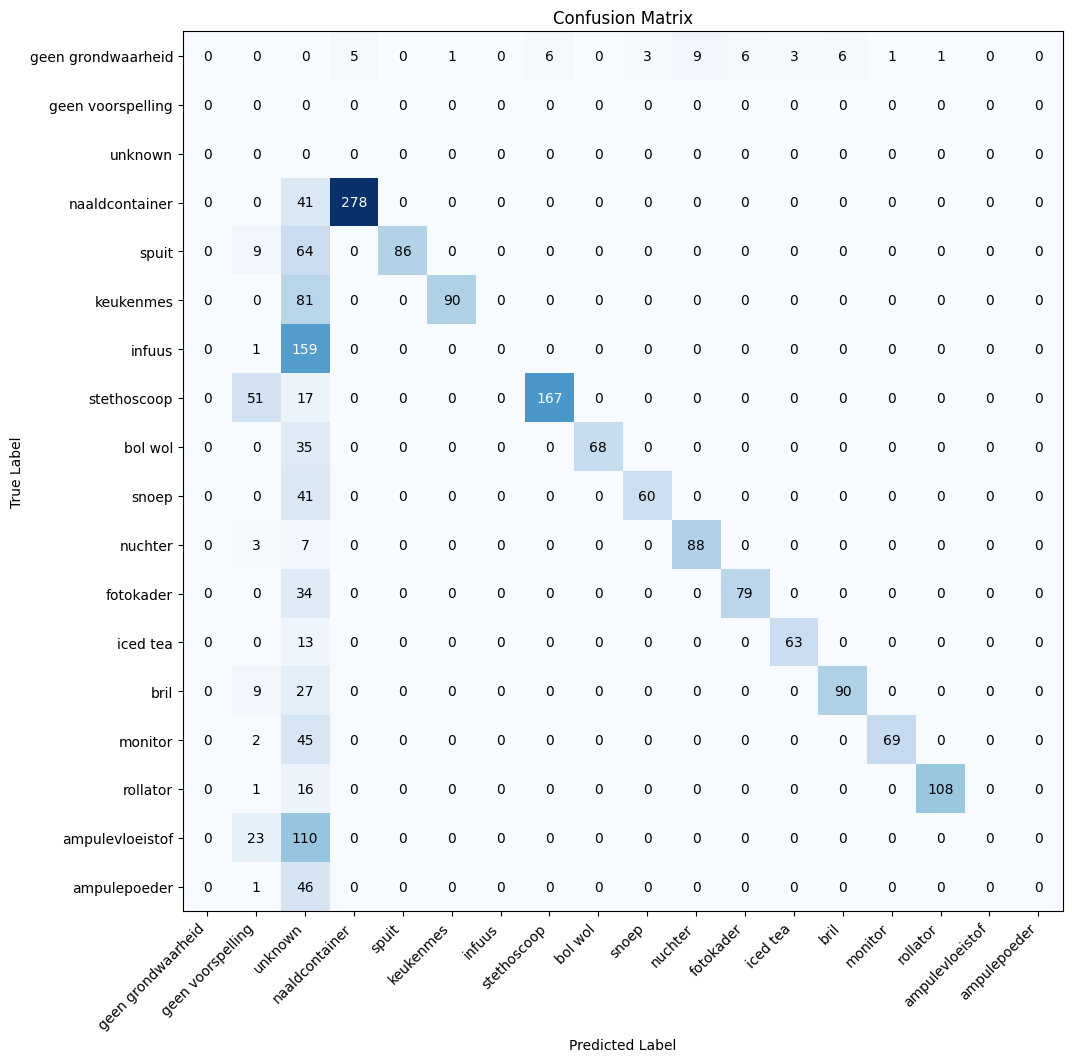

Overall accuracy: 0.5869
Known accuracy: 0.8983
Micro-averaged metrics:
  Precision: 0.9681
  Recall: 0.5985
  F1: 0.7397

Per-class metrics:
Class ID   Precision  Recall     F1         Support    Unknown Rate   
----------------------------------------------------------------------
1          0.9823     0.8715     0.9236     319        0.1285         
2          1.0000     0.5409     0.7020     159        0.4025         
3          0.9890     0.5263     0.6870     171        0.4737         
4          0.0000     0.0000     0.0000     160        0.9938         
5          0.9653     0.7106     0.8186     235        0.0723         
6          1.0000     0.6602     0.7953     103        0.3398         
7          0.9524     0.5941     0.7317     101        0.4059         
8          0.9072     0.8980     0.9026     98         0.0714         
9          0.9294     0.6991     0.7980     113        0.3009         
10         0.9545     0.8289     0.8873     76         0.1711         
11    

In [ ]:
def validate_confusion_matrix(
    cm_metrics: dict,
    ground_truth_df: pd.DataFrame,
):
    ground_truth_df = experiment_utils.get_ground_truth_df()
    true_support_per_class = ground_truth_df["class_id"].value_counts()
    for class_id, metrics in cm_metrics["per_class"].items():
        support = metrics["support"]
        true_support = true_support_per_class[class_id]

        if support != true_support:
            raise ValueError(
                f"Support for class {class_id} does not match. "
                f"Expected: {true_support}, "
                f"Got: {support}. "
            )
        
ground_truth_df = experiment_utils.get_ground_truth_df()

for model in models:
    model_name = model.stem
    model = YOLO(model)
    
    prediction_results_path = OBJECT_DETECTION_PREDICTIONS_PATH / model_name
    if prediction_results_path.exists():
        shutil.rmtree(prediction_results_path)
    prediction_results_path.mkdir(parents=True, exist_ok=True)

    cm = experiment_utils.create_confusion_matrix()
    comparison_sets = (COMPARISON_SETS_PATH / model_name).iterdir()
    for comparison_set_path in comparison_sets:

        predictions_df = get_predictions_df(
            model=model,
            comparison_set_path=comparison_set_path,
            min_pred_conf=0.8,
            iou_threshold=0.5,
        )
        
        predictions_df.to_csv(
            prediction_results_path / f"{comparison_set_path.stem}.csv",
            index=False,
        )

        gt_df_recording = ground_truth_df[
            ground_truth_df["recording_id"] == comparison_set_path.stem
        ].copy()

        eval_df = experiment_utils.evaluate_predictions(
            predictions_df=predictions_df,
            gt_df=gt_df_recording,
            iou_threshold=1.0,
        )

        experiment_utils.update_confusion_matrix(cm, eval_df)

    experiment_utils.render_confusion_matrix(cm)
    cm_metrics = experiment_utils.confusion_matrix_metrics(cm)

    experiment_utils.print_confusion_matrix_metrics(cm_metrics)

    validate_confusion_matrix(cm_metrics, ground_truth_df)


# Render Final Predictions

In [3]:
def draw_video_frames(
    session: Session,
    frames: list[Path],
    frame_to_gaze_position: dict[int, tuple[int, int]],
    predictions_df: pd.DataFrame,
    draw_unknowns: bool = False
):
    # Iterate over frames and draw the annotations on them if they exist
    for frame in tqdm(frames, desc="Drawing annotations on frames"):
        frame_idx = int(frame.stem)
        frame_img = cv2.imread(str(frame))

        # iterate through the predictions with the same frame index
        frame_predictions = predictions_df[predictions_df["frame_idx"] == frame_idx]
        for _, row in frame_predictions.iterrows():
            class_id = int(row["predicted_class_id"])
            class_name = CLASS_ID_TO_NAME[class_id]
            box = (int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"]))

            try:
                simroom_class = simrooms_service.get_simroom_class(session, class_id)
                color = simroom_class.color
            except:
                if draw_unknowns:
                    color = "#FF0000"
                else:
                    continue

            frame_img = image_utils.draw_labeled_box(
                frame_img, box, class_name, color
            )

        # Draw the gaze point on the frame
        if frame_to_gaze_position.get(frame_idx) is not None:
            gx, gy = frame_to_gaze_position[frame_idx]

            cv2.circle(
                frame_img,
                (int(gx), int(gy)),
                radius=VIEWED_RADIUS,
                color=(0, 0, 255),
                thickness=2,
            )

        # Save the modified image back to its original location
        cv2.imwrite(str(frame), frame_img)

In [4]:
for model in models:
    model_name = model.stem
    model = YOLO(model)
    
    if FINAL_PREDICTION_VIDEOS_PATH.exists():
        shutil.rmtree(FINAL_PREDICTION_VIDEOS_PATH)
    FINAL_PREDICTION_VIDEOS_PATH.mkdir(parents=True, exist_ok=True)

    prediction_results = (OBJECT_DETECTION_PREDICTIONS_PATH / model_name).iterdir()
    for prediction_result_path in prediction_results:
        recording_id = prediction_result_path.stem
        predictions_df = pd.read_csv(prediction_result_path)

        video_path = RECORDINGS_PATH / f"{recording_id}.mp4"

        frames, tmp_frames_dir = simrooms_service.extract_tmp_frames(recording_id)
        tmp_frames_path = Path(tmp_frames_dir.name)

        frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(recording_id, len(frames))

        with Session(engine) as session:
            draw_video_frames(
                session=session,
                frames=frames,
                frame_to_gaze_position=frame_to_gaze_position,
                predictions_df=predictions_df,
            )

        print(f"Creating video for {recording_id}")
        video_result_path = FINAL_PREDICTION_VIDEOS_PATH / f"{recording_id}.mp4"
        cmd = f'ffmpeg -hwaccel cuda -y -pattern_type glob -framerate {TOBII_GLASSES_FPS} -i "{str(tmp_frames_path)!s}/*.jpg" -c:v libx264 -pix_fmt yuv420p "{str(video_result_path)}"'
        subprocess.run(cmd, shell=True)


{0, 1, 2, 3}


Warning: Detected 3 gaze points for a frame in the video. This is unexpected.